## 椭圆曲线加密体系

我们已经知道如何构造一个基于有限域椭圆曲线加法群的循环子群，用其构造的明文和密文对$(n, n*G)$，可以用比RSA少的报文空间，提供相同的安全性，二者分别基于不同的NP类问题大数分解和离散对数难题。本文介绍基于有限域椭圆曲线的加解密、秘钥交换、签名等。

## ECDH 椭圆曲线秘钥交换
在 ECDH 跟(Diffie–Hellman Key Exchange)有点类似，只是不再通过简单的模幂运算，而是通过素数域下的椭圆曲线的标量乘法来实现。<br>
流程如下：<br>
Alice 和 Bob 生成各自的公私钥。假设 Alice 的私钥是a ，公钥则为aG ，Bob 的则是b  和bG 。他们用的同一个基点 G、同一个整数有限域，同一条椭圆曲线。<br>
Alice 和 Bob 通过不安全的信道交换公钥aG 和bG 。<br>
Alice 计算 $a*bG$，Bob 计算$b*aG$ ，共享密钥就是abG。

## EC-Elgamal加密体系
ECC主要还是用于签名，但也可以套用Elgamal加密机制，选择ECC椭圆曲线产生的加法群作为加密，具体加解密流程如下：<br>
Alice 和 Bob 生成各自的公私钥。假设 Alice 的私钥是a ，公钥则为aG ，Bob 的则是b 和bG 。他们用的同一个基点 G、同一个整数有限域，同一条椭圆曲线。<br>
Bob向Alice发送消息m，Elgamal机制要求把m表示为群的元素（即椭圆曲线上点$P_m$)，同时随机选择一个随机数r，产生$(rG, P_m+r*aG)$两个点，发送给alice. <br>
Alice 计算 $P_m+r*aG-a*rG=P_m$，得到$P_m$，注意的是此处并未得到明文m，ECElgamal的机制只是加密了循环群上的元素，这一点与在素数域中的做法有所不同。所以在实际应用中，通常是预留消息的8位字段，以确保m作为该曲线上的一个点的x坐标，能够对应到$P_m$，这样就可以把加密信息m编码到点的x坐标上来实现加解密。


## ECDSA 椭圆曲线签名
ECDSA 是 DSA 算法的变种，常用于数字签名，在比特币、以太坊等区块链里，采用的都是ECDSA签名算法。<br> 
Alice 通过椭圆曲线算法生成公私钥$(pk, P)$，对要签名的消息通过哈希算法sha1/sha256等生成摘要z(z为整数)，然后 Alice 按照下面步骤对摘要z 生成签名$(r, s)$。 Bob可以通过公钥P验证签名。<br>

生成签名<br>
1）Alice 选取一个随机数 k，其中 $k \in \{1, ... n-1 \} $ ，n为子群的阶。<br>
2）计算 $R=k*G$，G 是曲线的基点。<br>
3）计算$r=x_R \mod n $，如果 $r=0$，则回到第1步重新选择一个 k 重试。<br>
4）计算 $s=k^{-1}(z+r*pk) \mod p $。如果 $s=0$，则回到第1步重新选择一个 k 重试。<br>
5）$(r,s)$ 是一个2个20字节的数对，就是最终的签名<br>

验证签名<br>
1）计算 $u_1 = s^{-1}z \bmod n $。<br>
2）计算 $u_2 = s^{-1}r \bmod n $。<br>
3）计算 $Q = u_1G + u_2P $。<br>
4）如果 $x_Q \bmod n = r$，则签名有效<br>

本质上是验证方程 $s^{-1}(z*G+r*P) = R $，亦即 $s^{-1}(z*G+r*pk*G) = k*G $，等价于验证 $s^{-1}(z+r*pk) = k $，按前面s的定义方式即可知本方程成立。

### ECDSA的重要特性和sony PS3破解门
由于签名中添加了一个随机数k，所以即使对同一个消息签名都会得到不同的结果。<br>
索尼PlayStation-3最初的安全目标是使用椭圆曲线数字签名算法（ECDSA）来保护系统的安全， 然而索尼在使用椭圆曲线数字签名算法（ECDSA）进行签名处理时，该算法在生成随机化因子时缺乏随机化，索尼没有实际随机化种子值来进行每个签名。<br>
在2010年，黑客组织fail0overflow证明他们可以破坏索尼PS3的安全措施。他们重新创建了索尼的私钥，然后销毁了hypervisor和可执行签名。<br>
在fail0overflow大会上，他们展示了索尼ECDSA的部分代码，发现他们让种子的值保持4，实际上正确的做法是应该要有一套严密的伪随机数生成算法来使得每次生成的种子值接近真正的随机。<br>
具体细节可以搜一下相关链接。

### ECDSA的几何意义
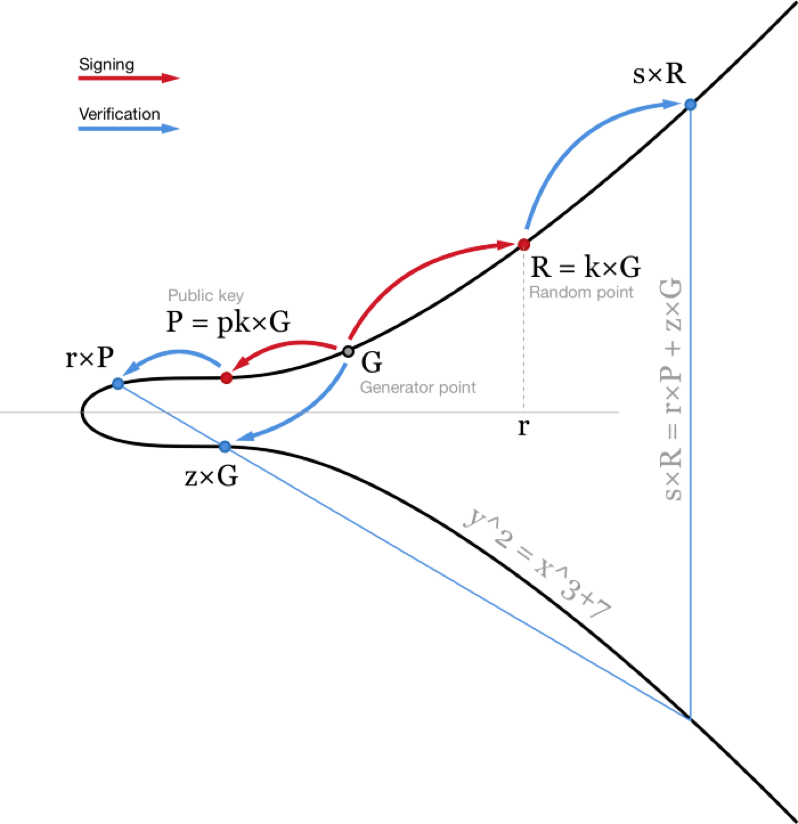


### ECDSA的应用场景和缺点
ECDSA在区块链里每笔交易都会用交易发起方签名，签名结果$(r,s)$随同其公钥P都会发布到网络里，矿工节点和其它用户都可以方便的验证该笔交易是否为有效签名，在比特币、以太坊等得到大量的采用。下图是比特币的UTXO交易结构，可以看到每笔交易里都是有$(R,S,PubKey)$的。
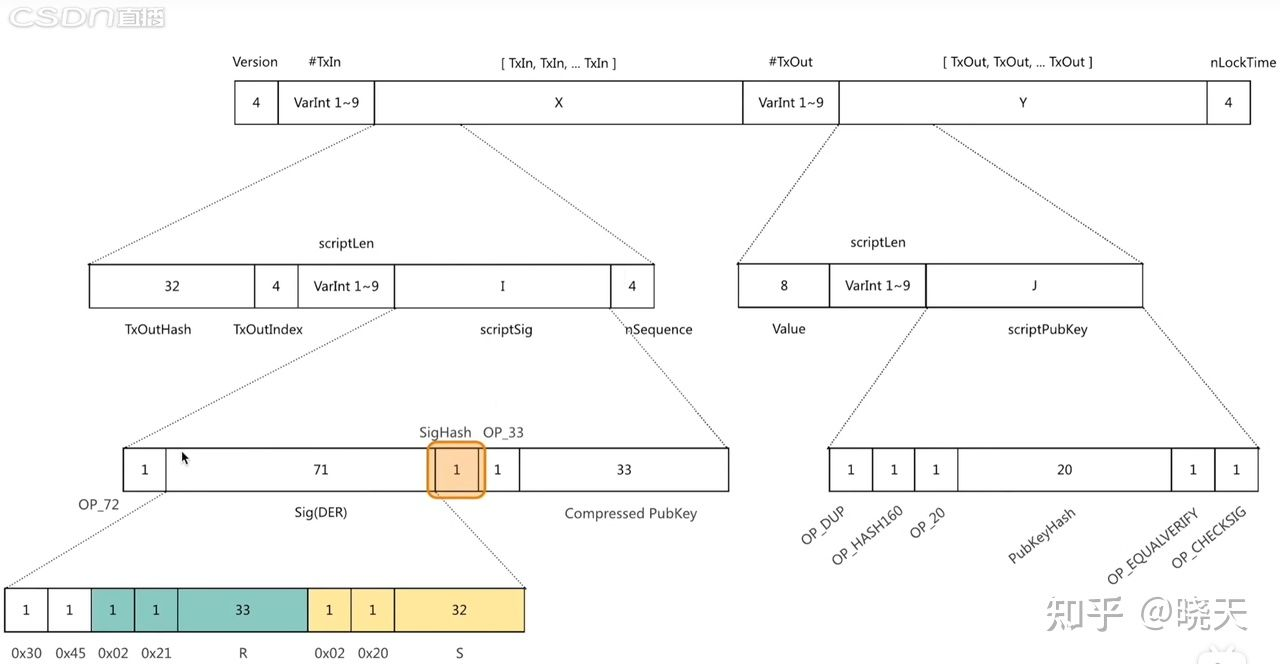

ECDSA有几个很大的缺点：<br>
1、要求每笔交易都要得到单独的签名，也就是每笔交易要附加最少40个字节的签名信息，这在区块链存储昂贵的成本下，显得代价很大<br>
2、如果在比特币这种非账户模型的UTXO模型下，如果要实现多签钱包，需要每个地址都要提交单独的签名上链，除了上面的存储成本高之外，还有一个问题是让比特币的多签地址和普通地址有一个明显的不同。<br>
因此2021年11月份，BTC通过了一个重大的升级（自2017年隔离见证segwit以来首次），即taproot升级，其中签名方案从ECDSA改为Schnorr方案。<br>
从计算机工程的角度来说Schnorr方案看起来比ECDSA要好很多，但有些数学家们有些不同意见，具体可以搜索彩虹签名相关信息进一步了解。

## Schnorr签名
与ECDSA不同之处在于，这里使用了一个点 R 和一个标量 s 来代替两个标量（r，s）。与 ECDSA 相似的是，R 是椭圆曲线（R=K×G）上的一个随机点。签名的第二部分计算略有不同：$s = k + hash(P,R,m) * pk $. 这里的 pk 是私钥，而 $P = pk×G$ 则是公钥，m 是消息。然后可通过检查 $s×G = R + hash(P,R,m)×P$ 来验证这个签名，其中hash(P,R,m)是根据公开的输入(P, R, m)而确定的信息，类似于ECDSA算法的z。
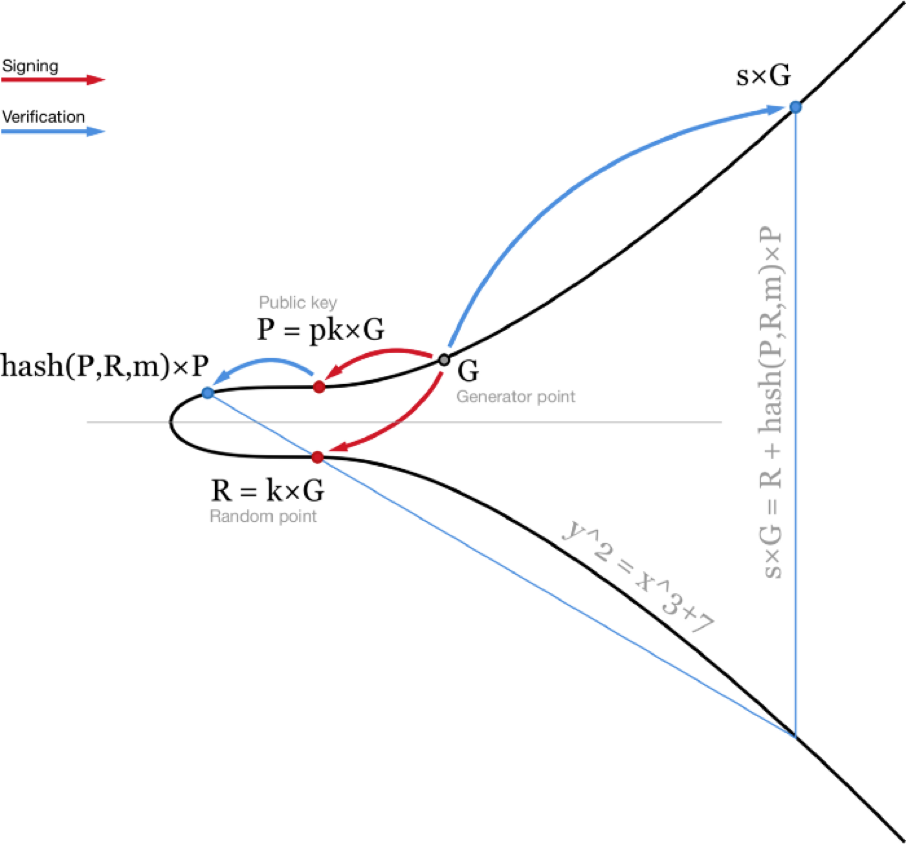
     
### Schnorr签名的特点
中本聪在设计比特币协议时，需要考虑到签名算法的签名长度、是否开源、是否有专利、是否经过足够长时间的安全验证、性能等多种条件。当时能满足上述这些条件的数字签名算法不止有 ECDSA，还有 Schnorr Signature 这个从各个方面都不亚于 ECDSA 的数字签名算法。但是由于在 2008 年之前处于专利保护的状态，所以可能是这个原因使得中本聪在设计比特币协议时并未使用该签名算法，最终选择了椭圆曲线数字签名算法（ECDSA），还在其他专家的建议下选择了一条特殊的椭圆曲线 secp256k1。<br>
时隔10年，2018 年 7 月，比特币开发者 Pieter Wuille 撰写了 bip-schnorr提出了将 bitcoin 的签名算法更改为 schnorr 方案。Schnorr 与 ECDSA 虽然同为使用 secp256k1 曲线的椭圆曲线加密算法，但由于Schnorr Signature 在密码学特性上的优势，可以在几乎同等安全的基础上，更方便的构建多签名交易。Schnorr 使用在比特币上，相比ECDSA会有一些额外的显著优势：<br>

更安全：在随机预言模型中很容易证明 Schnorr 签名的安全性，而 ECDSA 不存在这样的证明。<br>
无延展性困扰：ECDSA签名是可延展性的，第三方无需知道私钥，可以直接修改既有签名，依然能够保持该签名对于此交易是有效的。比特币一直存在延展性攻击，直到SegWit激活后才修复，前提是使用segwit交易，而不是传统交易。BIP62 和 BIP66 对此有详细描述。<br>
线性：Schnorr签名算法是线性的！以这一特性作为基础，可以构建更高效和隐私性更强的区块链系统。使用 Schnorr 签名的各方可以生成对其各自密钥的签名聚合。例如，N个公钥进行签名，采用ECDSA的话，则有N个签名，验证同样需要做N次。若使用Schnorr，由于线性特性，则可以进行签名叠加，仅保留最终的叠加签名。例如同一个交易无论输入数量多少，其均可叠加为一个签名，一次验证即可。<br>
Schnorr签名算法几乎在各个层面均优于比特币现有的签名算法ECDSA：性能，安全，体积，扩展性等方面等，并且Schnorr Sig可以与ECDSA使用同一个椭圆曲线：secp256k1 curve，升级起来的改动非常小。<br>

当然在比特币协议中除了签名算法之外，还设计了Taproot 脚本语言定义如何使用比特币。比特币多签类地址可以不用暴露出自己的「多签」身份，也可以支持数量众多的多签场景（链上交易只需要一个聚合的公钥和一个签名），降低很多的交易字节数，特别是对于需要高频操作的地址而言，降低链上的交易费用，可以节省不少的成本。<br>

### Schnorr的线性特点
schnorr等式是线性的，所以多个等式可以相加相减而等号仍然成立。这给我们带来了 Schnorr 签名的多种良好特性。<br>
在验证区块链上的一个区块时，我们需要验证区块中所有交易的签名都是有效的。如果其中一个是无效的，无论是哪一个 —— 我们都必须拒绝掉整个区块。<br>
ECDSA 的每一个签名都必须专门验证，意味着如果一个区块中包含 1000 条签名，那我们就需要计算 1000 次除法和 2000 次点乘法，总计约 3000 次繁重的运算。<br>
但有了 Schnorr 签名，我们可以把所有的签名验证等式加起来并节省一些计算量。在一个包含 1000 笔交易的区块中，我们可以验证：<br>
$(𝑠_1+𝑠_2+…+𝑠_{1000})×𝐺=(𝑅_1+…+𝑅_{1000})+(ℎ𝑎𝑠ℎ(𝑃_1,𝑅_1,𝑚_1)×𝑃_1+ℎ𝑎𝑠ℎ(𝑃_2,𝑅_2,𝑚_2)×𝑃_2+…+ℎ𝑎𝑠ℎ(𝑃_{1000},𝑅_{1000},𝑚_{1000})×𝑃_{1000})(s_1+s_2+…+s_{1000})×G=(R_1+…+R_{1000})+(hash(P_1,R_1,m_1)×P_1+hash(P_2,R_2,m_2)×P_2+…+hash(P_{1000},R_{1000},m_{1000})×P_{1000}) $ <br>
这里就是一连串的点加法（从计算机运算的角度看，简直是免费的）和 1001 次点乘法。已经是几乎 3 倍的性能提升了 —— 验证时只需为每个签名付出一次重运算。<br>

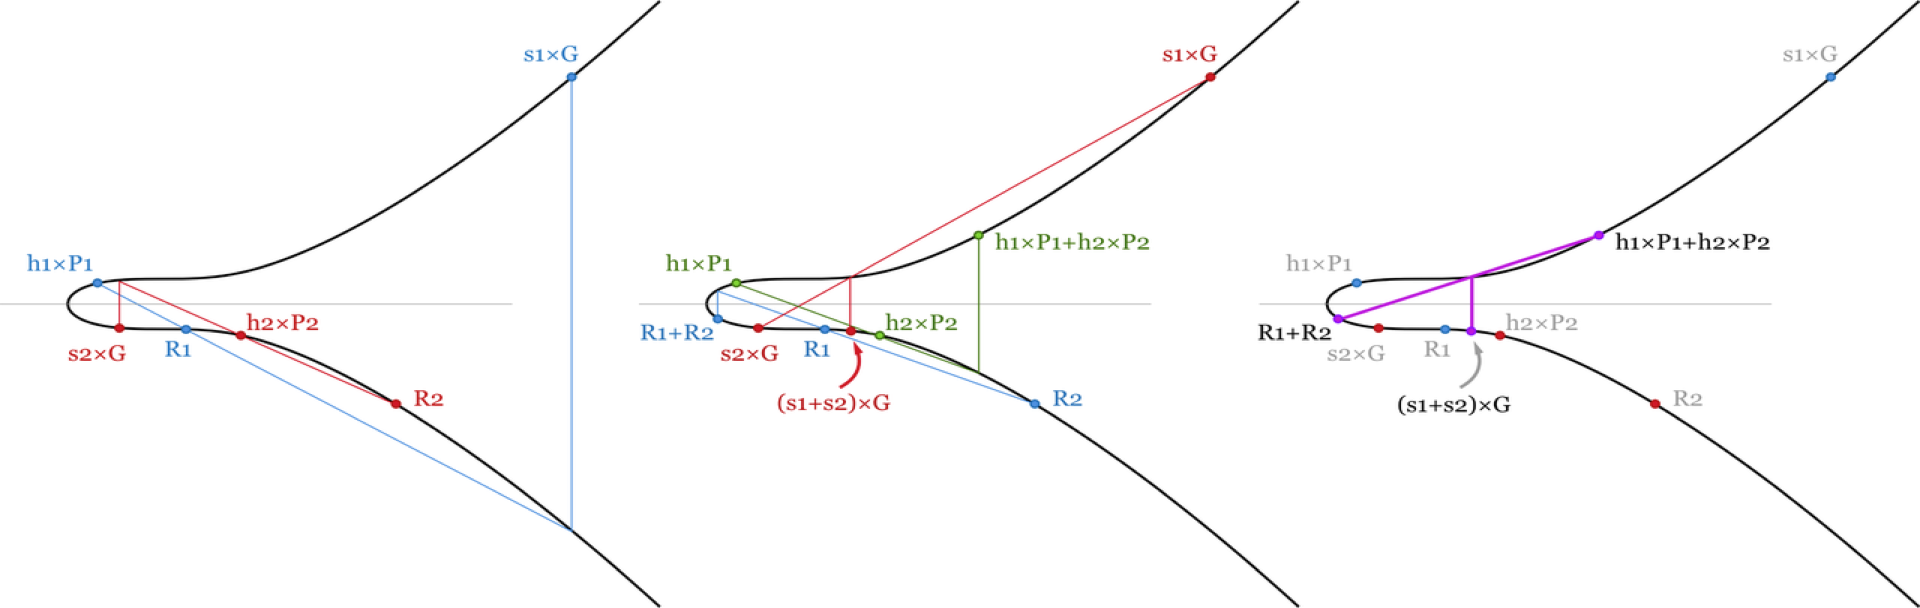

### Schnorr签名-多签的实现方式
有了 Schnorr 签名，我们可以使用一对密钥 $(pk_1,pk_2)$，并使用一个共享公钥 $𝑃=𝑃_1+𝑃_2=𝑝𝑘_1∗𝐺+𝑝𝑘_2∗𝐺$ 生成一个共同签名。在生成签名时，我们需要在两个设备上分别生成一个随机数 $(k_1, k_2)$，并以此生成两个随机点 $𝑅_𝑖=𝑘_𝑖∗𝐺 $，再分别加上 $ℎ𝑎𝑠ℎ(𝑃,𝑅_1+𝑅_2,𝑚)$，就可以获得 $s_1$ 和 $s_2$ 了（因为 $𝑠_𝑖=𝑘_𝑖+ℎ𝑎𝑠ℎ(𝑃,𝑅,𝑚)∗𝑝𝑘_𝑖$ ）。最后，把它们都加起来即可获得签名 $(𝑅,𝑠)=(𝑅_1+𝑅_2,𝑠_1+𝑠_2)$，这就是我们的共享签名，可用共享公钥来验证。其他人根本无法看出这是不是一个聚合签名，它跟一个普通的 Schnorr 签名看起来没有两样。

